# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Для выполнения проекта я выполню следующие шаги:
1. Открою файл и изучу данные
2. Разобью данные на обучающую, валидационную и тестовую выборки
3. Разделю каждую выборку на параметры и целевой показатель (тариф)
4. Поочередно рассмотрю модели дерева решений, случайного леса и логистической регрессии:
- задам диапазон изменения гиперпараметров модели
- обучу соответствуюшую модель на тестовых данных с заданными гиперпараметрами
- предскажу значение целевого параметра на валидационной выборке
- оценю значение accuracy полученной модели
- по значению accuracy выберу наилучшие гиперпараметры соответствующей модели
5. Сравнив значения accuracy всех трех моделей с наилучшими значениями гиперпараметров выберу одну из них для дальнейшего использования.
6. Проведу исследование на тестовой выборке:
- при помощи выбранной модели предскажу значения целевого параметра на тестовой выборке
- оценю знаечние accuracy для тестовой выборки
- при необходимости,в ернусь на предыдущий этап
7. Проверю на адекватность модели,с раввнив значение их accuracy с результатми случайных предсказаний.

## Откройте и изучите файл

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Посмотрим на данные в датасете

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


У нас в распоряжении 3214 строк, бзе пропусков,все готов к анализу.

Посмотрим на описание статистик по данным

In [ ]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Медианны значения количества звонок,минут,сообщений и Мб: 62, 430 30, 16943 и медианное значение тарифа - Смарт

<AxesSubplot:>

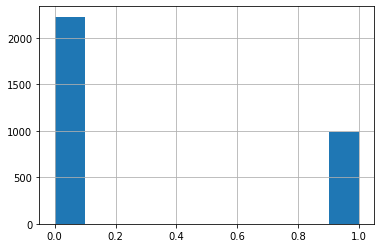

In [ ]:
df['is_ultra'].hist()

Серьезный перевес в сторону Смарта в выборке

**Вывод**

Знакомство с данными осуществлено, можно перейти к обработке

## Разбейте данные на выборки

Разобьем датасет на признаки и целевой показатель -тариф

In [ ]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

Разобьем датасет на обучающую выборку, тестовую и валидационную в пропоцрии 60% на 20% на 20%. Для начала выделим 60% обучающей выборки:

In [ ]:
features_train, features1, target_train, target1 = train_test_split(features, target, test_size=0.4,
                                                                    random_state=12345, stratify = target)
print(features_train.shape)
print(features1.shape)
print(target_train.shape)
print(target1.shape)

(1928, 4)
(1286, 4)
(1928,)
(1286,)


А теперь разделим оставшиеся 40% на валидационную и тестовые выборки, пополам, по 20% от исходной:

In [ ]:
features_valid, features_test, target_valid, target_test = train_test_split(features1, target1, test_size=0.5,
                                                                            random_state=12345, stratify = target1)
print(features_valid.shape)
print(features_test.shape)
print(target_valid.shape)
print(target_test.shape)

(643, 4)
(643, 4)
(643,)
(643,)


**Вывод**
Выборки разделены корректно в требуемом соотношении


## Исследуйте модели

Начнем с исследования модели -дерева решений. В качестве изменяемого гиперпараметра - глубина дерева. просмотрим модели с глубиной дерева от 1 до 10, оценивая для каждого из вараинтов знаечние accuracy на валидационной выборке для выбора наилучшего значения данного параметра:

In [ ]:
best_tree_model = None
best_tree_result = 0
best_samples_leaf = 2
best_samples_split = 2
best_tree_depth = 1

for depth in range(1, 10):
    for samples_split in range (2, 10):
        for samples_leaf in range (2, 10):
            model = DecisionTreeClassifier(random_state=12345, max_depth=depth,min_samples_split=samples_split,
                                           min_samples_leaf=samples_leaf)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            result = accuracy_score(target_valid, predictions)
            if result > best_tree_result:
                best_tree_depth = depth
                best_tree_model = model
                best_tree_result = result
                best_samples_leaf = samples_leaf
                best_samples_split = samples_split

print(f"Accuracy лучшей модели:{best_tree_result}. максимальная глубина:{best_tree_depth}")
print(f"Кол-во примеров для разбиения:{best_samples_split}.Кол-во примеров для решения:{best_samples_leaf}")

Accuracy лучшей модели:0.8040435458786936. максимальная глубина:8
Кол-во примеров для разбиения:8.Кол-во примеров для решения:3


Наилучшая глубина - 8, значение accuracy - 0.804, лучшее кол-во примеров для разбиения: 8, лучшее кол-во примеров для решения: 3

Перейдем к изучению модели случайного леса, будем изменять параметры количества деревьев от 1 до 50 с шагом 5 и с глубиной дерева от 1 до 10:

In [ ]:
best_forest_model = None
best_forest_result = 0
best_forest_est = 0
best_forest_depth = 0
best_samples_split = 2
for est in range(1, 51, 5):
    for depth in range (1, 10):
        for samples_split in range (2, 10):
            model = RandomForestClassifier(random_state=12345, n_estimators=est,
                                           max_depth=depth, min_samples_split=samples_split)
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)
            result = accuracy_score(target_valid, predictions_valid)

            if result > best_forest_result:
                best_forest_model = model
                best_forest_result = result
                best_forest_est = est
                best_forest_depth = depth
                best_samples_split = samples_split

print(f"Accuracy лучшей модели:{best_forest_result}. Максимальная глубина:{best_forest_depth}")
print(f"Количество деревьев:{best_forest_est}. Кол-во примеров для разбиения:{best_samples_split}")

Accuracy лучшей модели:0.8195956454121306. Максимальная глубина:9
Количество деревьев:36. Кол-во примеров для разбиения:2


Наилучшая accuracy = 0.8196 у случайного леса при максимальной глубине дерева 9, 36 деревьях и 2 примерах для разделения на ветви.

Перейдем к изучению модели логистической регрессии,  переберем несоклько вараинтов алогритмов оптимизации:

In [ ]:
solvers= ['liblinear', 'lbfgs', 'sag', 'saga'] #solvers[i]
best_regress_model = None
best_regress_result = 0
best_regress_solver = ''
best_regress_c = 0.01
for i in range(len(solvers)):
    for reg in range(0, 101, 5):
        model = LogisticRegression(random_state=12345, solver=solvers[i], max_iter=10000, C=reg+0.01)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        if result > best_regress_result:
            best_regress_solver = solvers[i]
            best_regress_model = model
            best_regress_result = result
            best_regress_c = reg+0.01

print(f"Accuracy лучшей модели:{best_regress_result}, Solver лучшей модели: {best_regress_solver},коэффициент регуляризации лучшей модели: {best_regress_c}")

Accuracy лучшей модели:0.7387247278382582, Solver лучшей модели: lbfgs,коэффициент регуляризации лучшей модели: 0.01


Наилучший алгоритм - lbfgs, ,коэффициент регуляризации лучшей модели: 0.01, значение accuracy - 0.7387

**Вывод:**
Таким образом, по значению accurracy  выберем наиболее точной моделью случайный лес с количеством деревьем 36, числом примеров для создания ветвей -2, максималньой глубиной 9 и значением accuray = 0,8196

## Проверьте модель на тестовой выборке

Возьмем выбранную модель случайного леса и проверим ее предсказания на тетсовой выборке:

In [ ]:
predictions_valid = best_forest_model.predict(features_test)
result = accuracy_score(target_test, predictions_valid)
print("Accuracy лучшей модели случайного леса на тестовой выборке:", result)

Accuracy лучшей модели случайного леса на тестовой выборке: 0.807153965785381


**Вывод**:

Выбранная модель выдала на тестовой выборке accuracy 0.807,  что выше требуемых 0.75, требуемая точность достигнута.

## (бонус) Проверьте модели на адекватность

Для проверки модели на адекватность сравним ее ерзультат с результатом модели DummyClassifier со стратегией "самый частый"

In [ ]:
from sklearn.dummy import DummyClassifier
model = DummyClassifier(strategy='most_frequent', random_state=12345)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = accuracy_score(predictions_valid, target_valid)
print('Accuracy модели DummyClassifier:', result)

Accuracy модели DummyClassifier: 0.7060653188180405


Посмотрим на распределение классов с тренировочных данных:

In [ ]:
target_train.value_counts()/len(target_train)*100

0    69.346473
1    30.653527
Name: is_ultra, dtype: float64

**Вывод**

Значение accuracy модели DummyClassifier 0.706
Значение accuracy дерева решений:  0.785
Значение accuracy случайного леса: 0.8087
Значение accuracy логистической регресси: 0.71

Все значения выше значения accuracy модели DummyClassifuer и доли наиболее встречающегося тарифа Смарт(0.693),  а значит все модели являются адекватными.

## Общий вывод ##
- Файл с данными был открыт и изучен
- Данные были разбиты на обучающую, валидационную и тестовые выборки в соотношении 60:20:20
- Были выбраны наилучшие гипарпараметры для дерева решений, случайного леса, логистической регрессии:
    - Наилучшая глубина дерева решений - 3. Кол-во примеров для разбиения:8.Кол-во примеров для решения:3
    - Наилучшее количество деревьев для случайного леса 36, максимальная глубина 9,минимальное кол-во примеров для разбиения- 2
    - Наилучший алгоритм для логистической регреccии - `lbfgs`, коэффициент регуляризации -0.01
- Были сравнены значения accuracy у всех трех моделей с наилучшими параметрами и выбрана самая точная:
    - значение accuracy для дерева решений -  0.804
    - значение accuracy для случайного леса - 0.8196
    - значение accuracy для логистической регрессии - 0.7387
    
- Наилучшая точность accuracy у модели случайного леса.
- Для модели случайного леса была определена accuracy на тестовой выборке, она составила 0.807 что выше требуемых 0.75.
- Для оценки адекватности моделей была обучена модель `DummyClassifier`, оценена accuracy на валидационной выборке, она составила 0.706.
- Была проведена оценка адекватности всех трех моделей путем сравнения их значения accuracy на валидационной выборке со значением accuracy для модели `DummyClassifier`, значениt accuracy для всех трех моделей выше и они признаны адекватными/
- Таким образом, для наиболее точных предсказаний для данной задачи следуюет использовать модель случайного леса с количеством деревьев 36, максимальной глубиной 9 и минимальным количеством примеров для разбиения 2.
    


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
